## Analyze whether SNWD varies more from year to year or from place to place.

In [52]:
import pandas as pd
import numpy as np
import urllib
import math

In [53]:
import findspark
findspark.init("C:\opt\spark")

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [54]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [55]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
798
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
| 1811.159502467558| 460.5274358673955| 343.3754609236406|    493.5|SBBBBBSB| 48.8217|-100.4525|       SNWD|0.21585999994825408|0.16516195320429547|0.13697690891565673| 0.32277648388

In [56]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [63]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_3'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_3 FROM weather


,station,year,coeff_3
0,USC00320941,1999.0,343.375461
1,USC00320941,1956.0,-498.350502
2,CA005010191,2009.0,-1106.380403
3,CA005010640,2011.0,514.195921
4,CA005010640,2006.0,-341.097322


In [64]:
Query_lat = "SELECT DISTINCT latitude,longitude FROM weather"
lat_long = sqlContext.sql(Query_lat).collect()

In [65]:
latitude_list = [row[0] for row in lat_long]
longitude_list = [row[1] for row in lat_long]

In [66]:
print min(latitude_list),max(latitude_list)
print min(longitude_list),max(longitude_list)

48.0475 49.93
-102.55 -98.9167


In [68]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_3')
year_station_table.head(10)

station,CA004011250,CA004012485,CA004016521,CA004018960,CA005010191,CA005010480,CA005010485,CA005010640,CA005010QFQ,CA005012545,...,USC00327824,USC00328047,USC00328627,USC00328792,USC00328913,USC00328990,USC00329333,USC00329445,USW00024013,USW00094011
year,,,,,,,,,,,,,,,,,,,,,
1939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,186.825996,276.745810,NaN,NaN,443.338985,NaN,NaN,358.395829,NaN
1950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,178.422465,-40.749847,NaN,-10.547495,101.769491,NaN,-21.897656,277.589193,NaN
1951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-216.623139,45.427579,NaN,NaN,45.281913,NaN,265.290358,85.787850,NaN
1952.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,386.214531,445.111630,462.302533,814.437108,615.573814,561.639197,NaN,NaN,597.626446,NaN
1953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-179.183402,NaN,NaN,-559.057480,-43.731651,NaN,NaN,153.454996,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [69]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = '+str(RMS(year_station_table))
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)
print 'Fraction Explained 1 : ',(RMS(tbl_minus_station)*1.0/RMS(year_station_table))*100
print 'Fraction Explained 2 : ',(RMS(tbl_minus_year)*1.0/RMS(year_station_table))*100

total RMS                   = 593.153878274
RMS removing mean-by-station=  571.389109917
RMS removing mean-by-year   =  304.364718495
Fraction Explained 1 :  96.3306708168
Fraction Explained 2 :  51.3129441858


In [29]:
T=year_station_table
print 'initial RMS=',RMS(T)
mean_list=[]
station_list=[]
for i in range(20):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_list.append(RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)
    station_list.append(RMS(T))

initial RMS= 646.118083143
0 after removing mean by year    = 389.181405429
0 after removing mean by stations= 364.382933589
1 after removing mean by year    = 363.235446874
1 after removing mean by stations= 363.111681619
2 after removing mean by year    = 363.090825353
2 after removing mean by stations= 363.085841244
3 after removing mean by year    = 363.084162625
3 after removing mean by stations= 363.083418988
4 after removing mean by year    = 363.083033867
4 after removing mean by stations= 363.082819911
5 after removing mean by year    = 363.082697635
5 after removing mean by stations= 363.082626979
6 after removing mean by year    = 363.082585975
6 after removing mean by stations= 363.082562139
7 after removing mean by year    = 363.082548274
7 after removing mean by stations= 363.082540206
8 after removing mean by year    = 363.082535512
8 after removing mean by stations= 363.08253278
9 after removing mean by year    = 363.08253119
9 after removing mean by stations= 363.08253

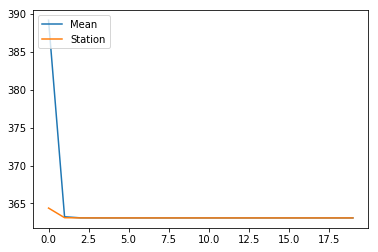

In [30]:
import matplotlib.pyplot as plt



plt.plot(mean_list, label="Mean")
plt.plot(station_list, label="Station")
plt.legend(loc="upper left")

plt.show()

In [14]:
mean_by_year.shape

(67L,)

In [15]:
T.shape

(67, 47)